# Modello di Regressione Logistica {#sec-logistit-regr}

**Prerequisiti**

- Si consiglia di ripassare i concetti fondamentali dell'analisi di regressione e dei modelli lineari generalizzati. Per approfondire, si rimanda al materiale didattico dell'insegnamento di Psicometria disponibile al link [https://ccaudek.github.io/psicometria/].

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [ ]:
# Carica il file _common.R per impostazioni di pacchetti e opzioni
here::here("code", "_common.R") |> source()

# Carica pacchetti aggiuntivi
pacman::p_load(car, LaplacesDemon, gmodels, effects, psych, jtools, see)

## Introduzione

Prima di immergerci nell'esplorazione dei modelli di Teoria della Risposta all'Item (IRT), è fondamentale acquisire una solida comprensione del modello di regressione logistica. Questo modello, ampiamente utilizzato per analizzare dati categorici, ci serve come solido punto di partenza per comprendere i più complessi modelli IRT. La regressione logistica, infatti, si occupa di stimare la probabilità che un evento avvenga, date certe variabili predittive. Analogamente, i modelli IRT si focalizzano sulla probabilità che un esaminando risponda correttamente a un item, basandosi su parametri che descrivono sia l'abilità dell'esaminando sia le caratteristiche dell'item.

Nonostante le somiglianze, i modelli IRT si distaccano in maniera sostanziale dalla regressione logistica per la loro capacità di modellare simultaneamente le proprietà degli item e le abilità degli individui. Mentre la regressione logistica assume che ogni osservazione sia indipendente, i modelli IRT considerano le interdipendenze tra le risposte agli item e tra gli item stessi. Nel presente capitolo, ci dedicheremo  ad esplorare il modello di regressione logistica.

## Modello di Regressione Logistica per Variabili Binarie

Il modello di regressione logistica si utilizza per analizzare la relazione tra una variabile dipendente dicotomica, che assume i valori di "successo" e "fallimento", e una o più variabili indipendenti, che possono essere sia quantitative che qualitative. Consideriamo $n$ osservazioni indipendenti, dove $Y_i$ indica l'osservazione $i$-esima della variabile risposta, per $i=1, \dots, n$. Ogni osservazione è associata a un vettore di variabili esplicative $(x_1, \dots, x_p)$. La relazione che vogliamo esaminare è tra la probabilità di successo $\pi_i$ e le variabili esplicative, espressa dalla formula:

$$
P(Y=1 \mid X=x_i) = \pi_i.
$$

In questo contesto, la variabile dipendente $Y$ segue una distribuzione di Bernoulli, con i seguenti possibili valori:

$$
y_i = 
\begin{cases} 
    1 & \text{per un successo (per l'osservazione $i$-esima)},\\
    0 & \text{per un fallimento}.
\end{cases}
$$

Le probabilità associate a questi valori sono rispettivamente $\pi$ per il successo e $1-\pi$ per il fallimento:

$$
\begin{aligned}
    P(Y_i = 1) &= \pi,\\
    P(Y_i = 0) &= 1-\pi.
\end{aligned}
$$

Questo modello permette quindi di studiare come le variabili esplicative influenzino la probabilità di un evento binario, quali il successo o il fallimento.

Per illustrare, consideriamo un dataset di 100 volontari, dove `age` è la variabile esplicativa e `chd` è la variabile risposta che indica la presenza (`chd` = 1) o assenza (`chd` = 0) di disturbi cardiaci. La media condizionata $\mathbb{E}(Y \mid X=x)$ in una popolazione può essere vista come la proporzione di valori 1 per un dato punteggio $x$ sulla variabile esplicativa (ad esempio, l'età), ovvero la probabilità condizionata $\pi_i$ di osservare la presenza di sintomi cardiaci in un certo gruppo d'età:

$$
\pi_i \equiv P(Y = 1 \mid X = x).
$$

Il valore atteso diventa:

$$
\mathbb{E}(Y \mid x) = \pi_i.
$$

Se $X$ è una variabile discreta, possiamo calcolare la proporzione di $Y=1$ per ogni valore di $X=x$ nel campione. Queste proporzioni rappresentano una stima non parametrica della funzione di regressione di $Y$ su $X$, e possono essere stimate tramite tecniche di smoothing, come indicato nella figura seguente.

In [3]:
chdage <- read.table("../../data/logistic_reg/chdage_dat.txt", header = TRUE)
chdage |>
    head()

,id,age,chd
,<int>,<int>,<int>
1,1,20,0
2,2,23,0
3,3,24,0
4,5,25,1
5,4,25,0
6,7,26,0


`geom_smooth()` using formula = 'y ~ x'


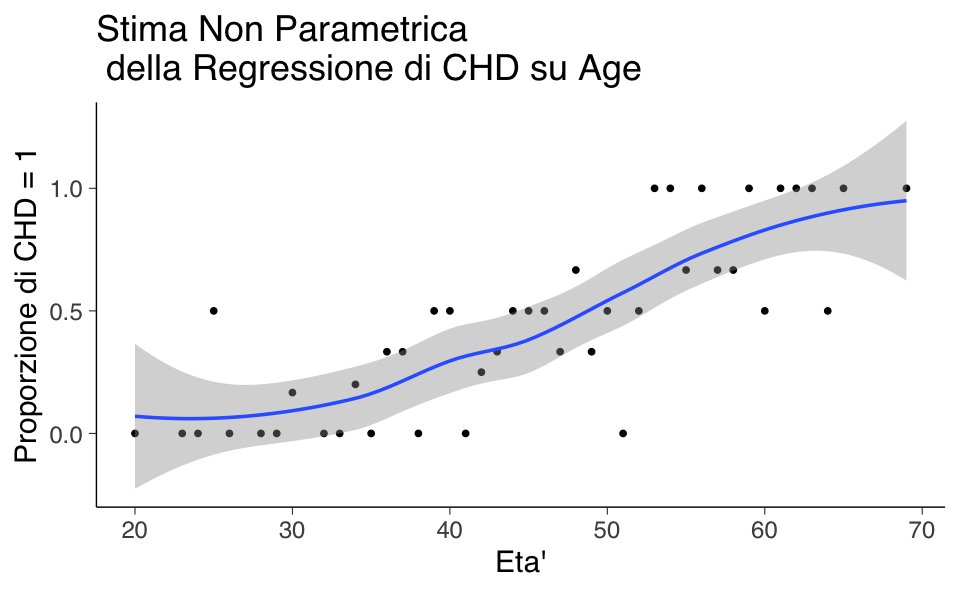

In [11]:
# Calcolo delle proporzioni di Y = 1 per ogni valore di X
prop_data <- chdage %>%
    group_by(age) %>%
    summarise(prop_chd = mean(chd))

# Grafico con smoothing
ggplot(prop_data, aes(x = age, y = prop_chd)) +
    geom_point() + # Mostra i punti di proporzione
    geom_smooth(method = "loess", span = 0.7) + # Regressione LOESS
    labs(
        title = "Stima Non Parametrica\n della Regressione di CHD su Age",
        x = "Eta'",
        y = "Proporzione di CHD = 1"
    ) 

Per valori bassi della variabile `age` la proporzione condizionata di valori $Y=1$ è prossima allo 0. Per valori alti dell'età la proporzione di valori $Y=1$ è prossima a 1.0. A livelli di età intermedi, la curva di regressione non parametrica gradualmente approssima i valori 0 e 1 seguendo un andamento sigmoidale. 

Anche se nel caso presente la regressione non parametrica produce un risultato sensato, è utile rappresentare la dipendenza di $Y$ da $X$ con una semplice funzione, in particolare quando ci sono molteplici variabili esplicative.

## Modello Lineare nelle Probabilità

Introduciamo un modello lineare con le seguenti assunzioni standard:

$$
Y_i = \alpha + \beta X_i + \varepsilon_i,
$$

dove $\varepsilon_i$ segue una distribuzione normale con media 0 e varianza 1 ($\varepsilon_i \sim \mathcal{N}(0, 1)$) e gli errori $\varepsilon_i$ e $\varepsilon_j$ sono indipendenti per ogni $i \neq j$. Il valore atteso di $Y_i$ è quindi $\mathbb{E}(Y_i) = \alpha + \beta X_i$, portando a:

$$
\pi_i = \alpha + \beta X_i.
$$

Questo è noto come *modello lineare nelle probabilità* (*linear probability model*). Tuttavia, questo approccio presenta una limitazione significativa: non garantisce che i valori predetti di $\pi_i$ siano confinati nell'intervallo [0,1], come richiesto per le probabilità.

### Problemi di Normalità

Considerando che $Y_i$ può assumere solo i valori 0 o 1, i residui $\varepsilon_i$ risultano anch'essi dicotomici e quindi non possono seguire una distribuzione normale. Ad esempio, se $Y_i=1$ con probabilità $\pi_i$, il residuo sarà:

$$
\varepsilon_i = 1 - \mathbb{E}(Y_i) = 1 - (\alpha + \beta X_i) = 1 - \pi_i.
$$

Se, invece, $Y_i=0$ con probabilità $1-\pi_i$, il residuo sarà:

$$
\varepsilon_i = 0 - \mathbb{E}(Y_i) = 0 - (\alpha + \beta X_i) = - \pi_i.
$$

Tuttavia, se la dimensione del campione è grande, il teorema del limite centrale può mitigare l'importanza dell'assunzione di normalità per le stime dei minimi quadrati.

### Problematiche di Omoschedasticità

Utilizzare il metodo dei minimi quadrati può essere inappropriato in questo contesto poiché la varianza dei residui non è costante ma dipende dalla media, e quindi dalla variabile $X$. Assumendo che il modello sia lineare, abbiamo che $\mathbb{E}(\varepsilon_i)=0$. Sfruttando le relazioni discusse in precedenza, la varianza dei residui si calcola come:

$$
\mathbb{V}(\varepsilon_i) = (1-\pi_i)\pi_i.
$$

Consideriamo che la varianza dei residui $\varepsilon_i$ può essere espressa come:

$$
\text{Var}(\varepsilon_i) = \mathbb{E}(\varepsilon_i^2) - \mathbb{E}(\varepsilon_i)^2,
$$

dove $\mathbb{E}(\varepsilon_i^2)$ è il valore atteso del quadrato dei residui e $\mathbb{E}(\varepsilon_i)^2$ è il quadrato del valore atteso dei residui.

Ora calcoliamo $\mathbb{E}(\varepsilon_i^2)$:

$$
\begin{align*}
\mathbb{E}(\varepsilon_i^2) &= \mathbb{E}[(Y_i - \mathbb{E}(Y_i))^2] \\
&= \mathbb{E}[(Y_i - \pi_i)^2] \\
&= \mathbb{E}[(Y_i^2 - 2Y_i\pi_i + \pi_i^2)] \\
&= \mathbb{E}(Y_i^2) - 2\mathbb{E}(Y_i\pi_i) + \mathbb{E}(\pi_i^2) \\
&= \mathbb{E}(Y_i) - 2\mathbb{E}(Y_i\pi_i) + \pi_i^2 \\
&= \pi_i - 2\pi_i^2 + \pi_i^2 \\
&= \pi_i - \pi_i^2 \\
&= \pi_i(1 - \pi_i)
\end{align*}
$$

Ora calcoliamo $\mathbb{E}(\varepsilon_i)^2$:

$$
\begin{align*}
\mathbb{E}(\varepsilon_i)^2 &= (\mathbb{E}(Y_i - \mathbb{E}(Y_i)))^2 \\
&= (\mathbb{E}(Y_i - \pi_i))^2 \\
&= (0)^2 \\
&= 0
\end{align*}
$$

Quindi, sostituendo questi risultati nella formula della varianza dei residui, otteniamo:

$$
\text{Var}(\varepsilon_i) = \mathbb{E}(\varepsilon_i^2) - \mathbb{E}(\varepsilon_i)^2 = \pi_i(1 - \pi_i)
$$

Quindi, abbiamo dimostrato che la varianza dei residui nella regressione logistica può essere espressa come $(1-\pi_i)\pi_i$.

Dato che $\pi_i$ dipende da $x$, ciò significa che la varianza non è costante in funzione di $x$. Questa eteroschedasticità dei residui rappresenta un problema per le stime dei minimi quadrati nel modello lineare, specialmente quando le probabilità $\pi_i$ sono vicine a 0 o 1.

### Linearità

Il maggiore inconveniente connesso all'adozione del modello lineare nelle probabilità deriva dal fatto che la stima della probabilità di successo, $P(\hat{Y}_i=1)=\hat{\pi}_i$, non è necessariamente compresa nell'intervallo ($0,1$), ma può essere sia negativa sia maggiore di 1. Nel caso dell'esempio in discussione, ciò significa che la retta dei minimi quadrati produce valori attesi $\hat{\pi}$ inferiori a 0 per bassi valori della variabile età e valori $\hat{\pi}$ superiori a 1 per valori di età alti.

## Modello Lineare nelle Probabilità Vincolato

Una soluzione per mantenere $\pi$ all'interno dell'intervallo (0, 1) è la seguente specificazione del modello:

$$
\pi=
\begin{cases}
  0                           &\text{se $\alpha + \beta X < 0$},\\
  \alpha + \beta X           &\text{se $0 \leq \alpha + \beta X \leq 1$},\\
  1 &\text{se $\alpha + \beta X > 1$}.
\end{cases}
$$

Questo *modello lineare nelle probabilità vincolato* mostra alcune instabilità, soprattutto a causa della sua dipendenza critica dai valori estremi di $\pi$, dove assume i valori 0 o 1. La linearità di $\pi = \alpha + \beta X$ si basa fortemente sui punti in cui si verificano questi estremi. In particolare, la stima di $\pi = 0$ può essere influenzata dal valore minimo di $X$ associato a $Y=1$, mentre la stima di $\pi = 1$ può dipendere dal valore massimo di $X$ per cui $Y=0$. Questi valori estremi tendono a variare significativamente tra diversi campioni e possono diventare più estremi all'aumentare della dimensione del campione.

La presenza di più variabili esplicative ($k \geq 2$) complica ulteriormente la stima dei parametri del modello. Inoltre, il modello mostra un cambiamento brusco nella pendenza della curva di regressione ai punti estremi (0 e 1 di $\pi$), risultando poco realistico in molte situazioni pratiche. Questo rende il modello meno adatto a descrivere relazioni complesse e gradualmente variabili tra $\pi$ e $X$.

Una funzione che modella una relazione più fluida e continua tra $\pi$ e $X$ sarebbe più realistica e rappresentativa delle dinamiche osservate. Questo motiva la preferenza per modelli alternativi, come il modello di regressione logistica, che tende a fornire una rappresentazione più accurata e realistica delle interazioni tra variabili dicotomiche e esplicative.

## Regressione Logistica

Un metodo efficace per gestire il problema del vincolo sulle probabilità è specificare modelli non direttamente per le probabilità stesse, ma per una loro trasformazione che elimina tale vincolo. Invece di definire un modello lineare per la probabilità condizionata $\pi_i$, si può specificare un modello lineare per il logaritmo degli odds (logit):

$$
\eta_i = \log_e \frac{\pi_i}{1-\pi_i} = \alpha + \beta x_i,
$$

Questo approccio non presenta problemi poiché il logit $\eta$ è sempre un numero reale, permettendo di modellare una trasformazione lineare di $\pi$. L'immagine che segue è stata generata calcolando i *logit empirici*, ovvero il logaritmo degli odds $\log_e(\hat{\pi}_i/(1-\hat{\pi}_i))$ per 8 intervalli in cui è stata suddivisa la variabile "età". Questa analisi mostra chiaramente una relazione lineare tra i logit empirici e l'età, evidenziando come la regressione logistica possa efficacemente modellare e interpretare relazioni tra variabili trasformate e fattori esplicativi.

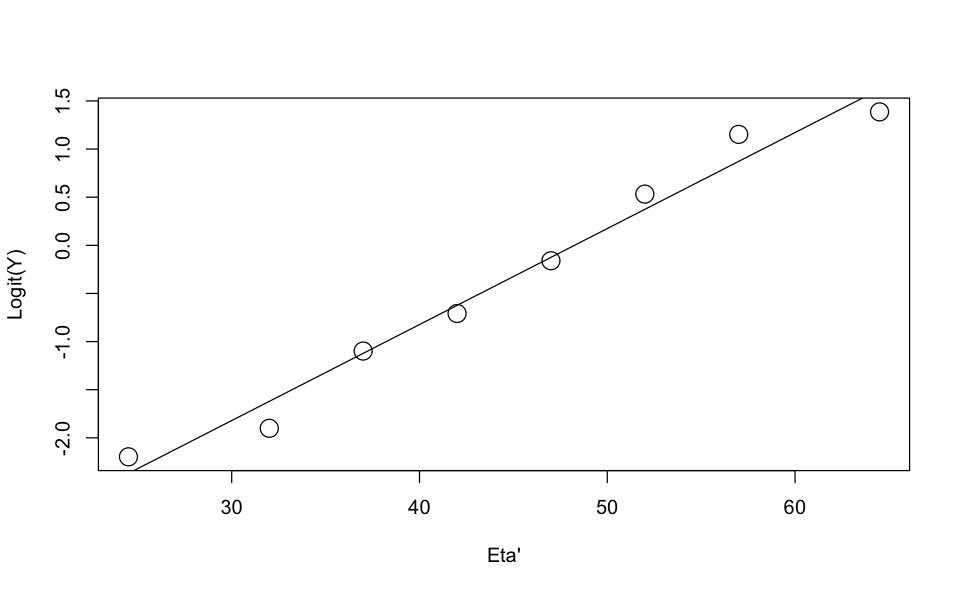

In [12]:
xc <- c(24.5, 32, 37, 42, 47, 52, 57, 64.5)
yc <- c(0.1, 0.13, 0.25, 0.33, 0.46, 0.63, 0.76, 0.8)
logit_y <- log(yc / (1 - yc))
fit2 <- lm(logit_y ~ xc)
plot(
    xc, logit_y,
    xlab = "Eta'", ylab = "Logit(Y)",
    main = "", type = "n"
)
points(xc, logit_y, cex = 2)
abline(fit2)

## Probabilità, Odds e Logit

La relazione tra probabilità, odds e logit viene illustrata nella tabella qui sotto. È importante notare che gli odds e il logit trasformano l'intervallo di probabilità (0, 1) in uno spettro più ampio. Gli odds rappresentano il rapporto tra la probabilità di un evento e la probabilità del suo complemento. Il logit, invece, è il logaritmo naturale degli odds, trasformando così l'intervallo di probabilità in tutta la linea dei numeri reali. Quando la probabilità è 0.5, gli odds sono 1 e il logit è 0. Logit negativi indicano probabilità inferiori a 0.5, mentre logit positivi indicano probabilità superiori a 0.5.

| Probabilità (P) | Odds (O)          | logit (L)         |
|-----------------|-------------------|-------------------|
| 0.01            | 0.01 / 0.99 = 0.0101 | $\ln(\frac{0.01}{0.99}) = -4.60$  |
| 0.05            | 0.05 / 0.95 = 0.0526 | $\ln(\frac{0.05}{0.95}) = -2.94$  |
| 0.10            | 0.10 / 0.90 = 0.1111 | $\ln(\frac{0.10}{0.90}) = -2.20$  |
| 0.30            | 0.30 / 0.70 = 0.4286 | $\ln(\frac{0.30}{0.70}) = -0.85$  |
| 0.50            | 0.50 / 0.50 = 1      | $\ln(\frac{0.50}{0.50}) = 0.00$   |
| 0.70            | 0.70 / 0.30 = 2.3333 | $\ln(\frac{0.70}{0.30}) = 0.85$   |
| 0.90            | 0.90 / 0.10 = 9      | $\ln(\frac{0.90}{0.10}) = 2.20$   |
| 0.95            | 0.95 / 0.05 = 19     | $\ln(\frac{0.95}{0.05}) = 2.94$   |
| 0.99            | 0.99 / 0.01 = 99     | $\ln(\frac{0.99}{0.01}) = 4.60$   |

### Trasformazione Inversa del Logit

La trasformazione inversa del logit, detta *antilogit*, consente di trasformare i logit in probabilità:

$$
  \pi_i =\frac{e^{\eta_i}}{1+e^{\eta_i}}.
$$ 

Logit e probabilità possono dunque essere trasformati gli uni nelle altre. La trasformazione inversa del logit consente di specificare un modello non lineare per le probabilità $\pi_i$. Tale modello non lineare è detto *logit*, o modello di regressione logistica:

$$
  \pi_i = \frac{e^{\eta_i}}{1+e^{\eta_i}} =  \frac{e^{\alpha + \beta x_i}}{1+e^{\alpha + \beta x_i}}.
$$

La funzione logistica ben rappresenta l'andamento sigmoidale delle proporzioni di casi $Y=1$, ovvero $\hat{\pi}_i = E(Y \mid x_i)$ (le proporzioni di presenza di disturbi coronarici), in funzione di livelli crescenti della variabile `age`:

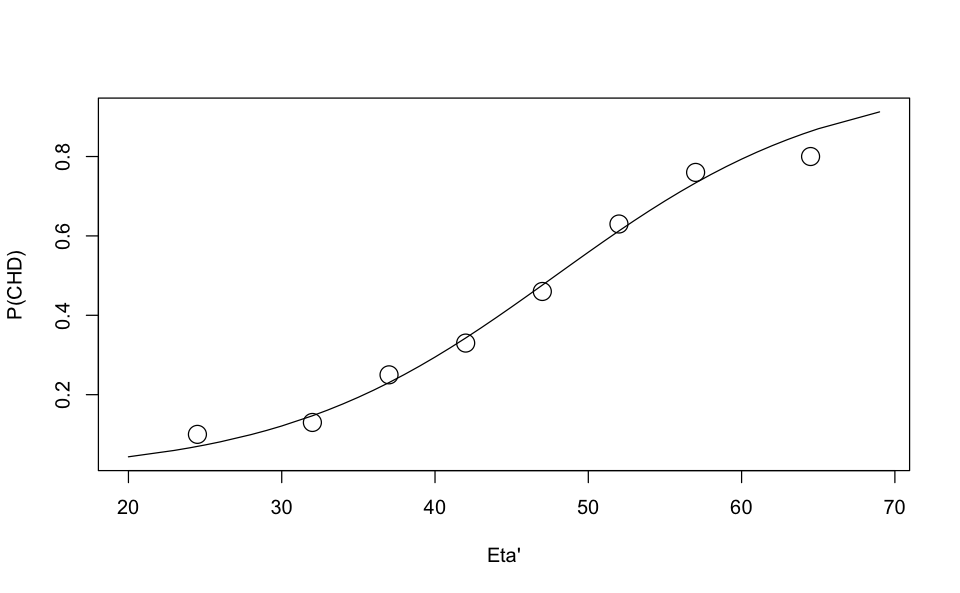

In [13]:
fm <- glm(chd ~ age, family = binomial(link = "logit"), data = chdage)
logit_hat <- fm$coef[1] + fm$coef[2] * chdage$age
pi_hat <- exp(logit_hat) / (1 + exp(logit_hat))

plot(chdage$age, pi_hat,
    xlab = "Eta'",
    ylab = "P(CHD)",
    main = "", type = "n"
)
lines(chdage$age, pi_hat)
xc <- c(24.5, 32, 37, 42, 47, 52, 57, 64.5)
yc <- c(0.1, 0.13, 0.25, 0.33, 0.46, 0.63, 0.76, 0.8)
points(xc, yc, cex = 2)

## Modelli Lineari Generalizzati 

Nel caso di una variabile risposta binaria, il modello classico di regressione lineare si scontra con sfide specifiche:

1. **Distribuzione Binomiale**: $Y_i$ segue una distribuzione binomiale (con indice $n_i$, potenzialmente uguale a uno nel caso individuale), rendendo non applicabile l'ipotesi di normalità.
2. **Limiti delle Probabilità**: Utilizzando una specificazione lineare come $\pi_i= \beta_0 + \beta_1 x_i$, si possono ottenere stime di probabilità esterne all'intervallo 0-1.
3. **Varianze Non Costanti**: La varianza di $\varepsilon$ varia in base alla specificazione del modello di probabilità, seguendo la formula $V(\varepsilon_i)=\pi_i(1-\pi_i)$.

Per superare queste sfide, si utilizzano i Modelli Lineari Generalizzati (GLM). Questi modelli consentono l'uso di variabili risposta di diversa natura e includono:

- **Regressione Lineare**: Per variabili dipendenti continue e variabili esplicative continue o qualitative.
- **Regressione Logistica**: Per variabili risposta binarie.
- **Modello Loglineare di Poisson**: Per modellare frequenze in tabelle di contingenza.

I GLM allentano alcune ipotesi fondamentali del modello lineare classico, come linearità, normalità della componente erratica, e omoschedasticità delle osservazioni. Sono strutturati in tre componenti principali:

1. **Componente Aleatoria**: Definisce la distribuzione di probabilità della variabile risposta $Y$.
2. **Componente Sistematica**: Specifica la relazione lineare tra le variabili esplicative e una trasformazione della variabile risposta.
3. **Funzione Legame**: Trasforma la media attesa $\mathbb{E}(Y)$ in un formato che possa essere modellato linearmente rispetto alle variabili esplicative. Non è la variabile risposta stessa ad essere modellizzata direttamente, ma una sua trasformazione, come il logit nel caso della regressione logistica.

Esempi di combinazioni di componenti aleatorie, funzioni di legame e sistematiche nei GLM includono:

| Componente Aleatoria | Funzione Legame | Componente Sistematica | Modello                |
|----------------------|-----------------|------------------------|------------------------|
| Gaussiana            | Identità        | Continua               | Regressione            |
| Gaussiana            | Identità        | Categoriale            | Analisi della varianza |
| Gaussiana            | Identità        | Mista                  | Analisi della covarianza |
| Binomiale            | Logit           | Mista                  | Regressione logistica  |
| Poisson              | Logaritmo       | Mista                  | Modello Loglineare     |

Questa struttura rende i GLM particolarmente flessibili e adatti a una vasta gamma di situazioni statistiche, superando i limiti del modello lineare classico.

## Componente Sistematica

La componente sistematica mette in relazione un vettore ($\eta_1, \eta_2, \dots, \eta_k$) con le variabili esplicative mediante un modello lineare. Sia $X_{ij}$ il valore della $j$-esima variabile esplicativa ($j=1, 2, \dots, p$) per l'$i$-esima osservazione ($i=1, \dots, k$). Allora 

$$
\eta_i = \sum_j \beta_j X_{ij}.
$$

Questa combinazione lineare di variabili esplicative è chiamata il *predittore lineare*. Un $X_{ij}=1, \forall i$ viene utilizzato per il coefficiente dell'intercetta del modello (talvolta denotata da $\alpha$).

## Componente Aleatoria

La  componente aleatoria del modello suppone l'esistenza di
  $k$ osservazioni indipendenti $y_1, y_2, \dots, y_k$, ciascuna delle
  quali viene trattata come la realizzazione di una variabile casuale
  $Y_i$. Si assume che $Y_i$ abbia una distribuzione binomiale:

$$
Y_i \sim Bin(n_i, \pi_i)
$$

con parametri $n_i$ e $\pi_i$. Per dati individuali (uno per ciascun valore $x_i$), $n_i=1,
    \forall i$.
  
## Funzione Legame

La  funzione legame $g(\cdot)$  mette in relazione il valore atteso della variabile risposta $Y_i$ con la componente sistematica $\eta_i$ del modello. Abbiamo visto che $\mathbb{E}(Y_i)=\pi_i$.
Che relazione c'è tra $\pi_i$ e il predittore lineare $\eta_i= \alpha + \sum_j  \beta_j X_{ij}$? 
La risposta a questa domanda è data dalla funzione legame:

$$
\eta_i = g(\pi_i) = \ln{\frac{\pi_i}{1-\pi_i}}
$$

Si noti che la funzione legame non trasforma la variabile risposta $Y_i$ ma bensì il suo valore atteso $\pi_i$.

La funzione legame è invertibile: anziché trasformare il valore atteso nel predittore lineare si può trasformare il predittore lineare nel valore atteso $\pi_i$:

$$
\pi_i = \frac{e^{\eta_i}}{1+e^{\eta_i}} =  \frac{e^{\alpha + \sum_j  \beta_j X_{ij}}}{1+e^{\alpha + \sum_j  \beta_j X_{ij}}}.
$$

Si ottiene così un modello non lineare per le probabilità $\pi_i$.

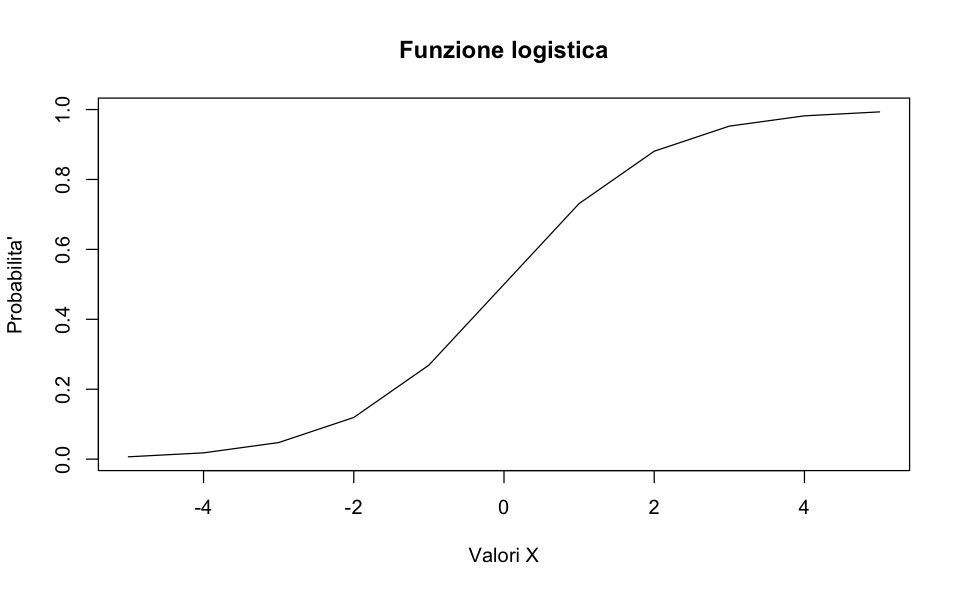

In [14]:
x <- -5:5
prob <- invlogit(x)
plot(x, prob, type = "l", main = "Funzione logistica", ylab = "Probabilita'", xlab = "Valori X")

## Regressione Logistica con R

La stima dei parametri del modello di regressione logistica per i dati in esame si ottiene in R utilizzando la funzione `glm()`: 

In [8]:
fm <- glm(chd ~ age,
    family = binomial(link = "logit"),
    data = chdage
)

Si noti che è necessario specificare sia la funzione teorica (`family = binomial`) della componente erratica del modello, sia la funzione legame (`link = "logit"`). L'output della funzione `glm()` può essere visualizzato utilizzando  `summary()`:

In [15]:
summary(fm) |>
    print()


Call:
glm(formula = chd ~ age, family = binomial(link = "logit"), data = chdage)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.30945    1.13365  -4.683 2.82e-06 ***
age          0.11092    0.02406   4.610 4.02e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 136.66  on 99  degrees of freedom
Residual deviance: 107.35  on 98  degrees of freedom
AIC: 111.35

Number of Fisher Scoring iterations: 4



Per i dati dell'esempio, le probabilità predette sono uguali a

$$
\hat{\pi}(x)=\frac{e^{-5.309 + 0.111 \times {\tt age}}}{1+e^{-5.309 + 0.111 \times {\tt age}}}.
$$

I logit stimati sono dati dall'equazione 

$$
\hat{\eta}(x)=-5.309 + 0.111 \times {\tt age}.
$$


## Interpretazione dei Coefficienti

Il modello di regressione logistica può essere interpretato focalizzandosi sui coefficienti di regressione. 

### Interpretazione Basata sui Log-Odds

1. **Intercetta (-5.30945):**
   - Rappresenta il log-odds di sviluppare CHD quando l'età è 0. Benché questo non sia praticamente realistico, offre un punto di riferimento teorico.
   - Il valore negativo suggerisce una bassa probabilità di CHD a 0 anni.

2. **Coefficiente di Età (0.11092):**
   - Indica la variazione dei log-odds di CHD per ogni anno aggiuntivo di età.
   - Un valore positivo implica che, all'aumentare dell'età, aumenta anche la probabilità di CHD.

### Interpretazione Attraverso l'Odds Ratio

Per calcolare l'odds ratio associato all'età, si esponenzia il coefficiente:

$$ 
\text{Odds Ratio per Età} = e^{0.11092} \approx 1.12.
$$

Questo valore mostra la variazione degli odds di CHD per ogni incremento annuale di età. Un odds ratio maggiore di 1 indica un aumento della probabilità con l'età. Ad esempio, un odds ratio di 1.12 significa che per ogni anno in più, gli odds di avere CHD aumentano del 12%. L'odds ratio fornisce una visione relativa e intuitiva del cambiamento del rischio.

### Interpretazione Basata sulle Probabilità Predette

L'interpretazione più diretta e intuitiva dei coefficienti nel modello di regressione logistica è tramite il calcolo delle probabilità predette. A differenza dei coefficienti grezzi o degli odds ratio, le probabilità predette offrono una comprensione immediata dell'impatto delle variabili.

Nel caso dello studio della probabilità di CHD in base all'età, si possono calcolare le probabilità predette di CHD per individui di diverse età. Questo metodo fornisce una rappresentazione chiara di come il rischio di CHD vari in funzione dell'età, rendendo l'interpretazione accessibile anche a chi non è esperto in statistica.

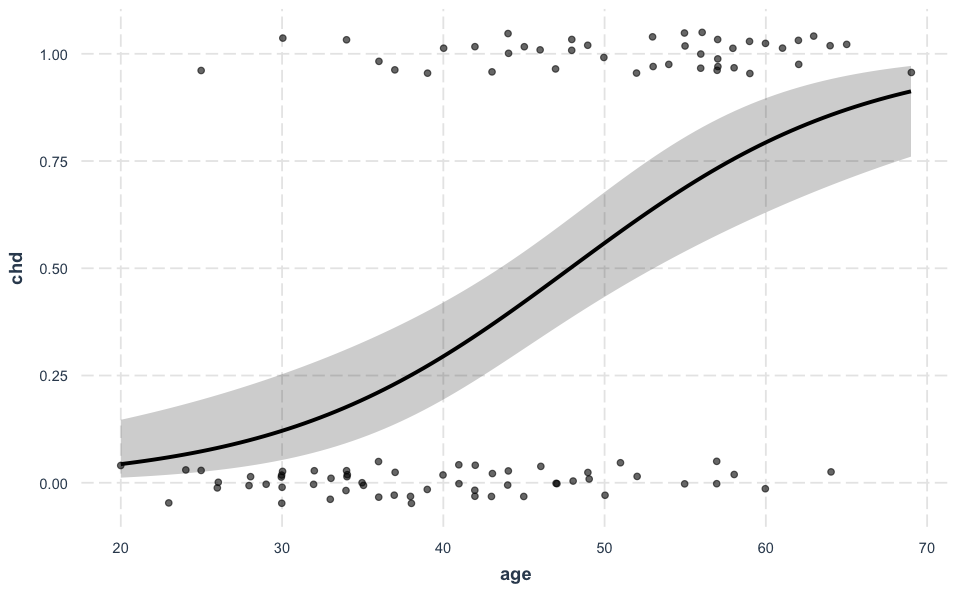

In [16]:
effect_plot(fm,
    pred = age, interval = TRUE, plot.points = TRUE,
    jitter = 0.05
)

## Considerazioni Conclusive

Nel caso di una variabile dipendente binaria $Y_i$, il tradizionale modello di regressione lineare non può essere applicato. Tale problema può essere risolto applicando il modello lineare non direttamente al valore atteso della variabile risposta, ma ad una sua trasformazione, il logit. La componente sistematica del modello di regressione lineare esprime il valore atteso della variabile dipendente come una funzione lineare dei predittori: $\mu_i = \boldsymbol{\beta x}_i$.

Per il modello di regressione lineare, il valore atteso di $Y$ è la media delle distribuzioni condizionate $Y \mid x_i$.

Per il modello di regressione logistica, il valore atteso della variabile risposta binaria, condizionato ad un determinato valore della variabile esplicativa (o ad un insieme di valori del vettore di variabili esplicative) è uguale alla probabilità che $Y$ assuma il valore 1:

$$
\mathbb{E}(Y \mid x_i) \equiv Pr(Y=1 \mid X=x_i) \equiv \pi_i.
$$

Tale valore atteso può essere interpretato come la proporzione di individui nella popolazione per i quali $Y=1$ in corrispondenza di $X=x_i$.

La componente sistematica del modello di regressione logistica rappresenta una trasformazione di $\pi_i$ come funzione lineare dei predittori:

$$
\ln \frac{\pi_i}{1-\pi_i} = \alpha + \beta X_i.
$$

Il modello è dunque lineare nei logit. Equivalentemente, esponenziando

$$
\frac{\pi_i}{1-\pi_i} = \exp(\alpha + \beta X_i)
$$

l'odds stimato di $Y_i=1$ è uguale a $\exp(\alpha + \beta X_i)$.

La funzione antilogit trasforma il predittore lineare $\eta_i = \alpha + \beta X_i$ nelle probabilità:

$$
\pi_i = \frac{\exp(\alpha+\beta X_i)}{1 + \exp(\alpha+\beta X_i)}.
$$

Il modello di regressione logistica è un modello non lineare nelle probabilità (ovvero, rispetto al valore atteso della variabile risposta).

La funzione logistica

$$
\Lambda(\eta) = \frac{\exp(\eta)}{1 + \exp(\eta)}
$$

viene  scelta quale funzione legame per trasformare la componente lineare del modello, $\eta_i =\alpha+\beta X_i$, nel valore atteso della variabile dipendente, $\pi_i$. Qualunque funzione cumulativa di probabilità potrebbe fungere da funzione legame, tuttavia, è conveniente scegliere la funzione logistica per facilità di interpretazione.

La componente aleatoria del modello di regressione logistica, infine, ci porta a considerare la variabile dipendente come una variabile aleatoria binomiale, sia nel caso di dati raggruppati (con denomiatore binomiale uguale alla frequenza delle osservazioni in ciascun gruppo $n_i$ corrispondente a modalità omogenee della/e variabile/i esplicativa/e) che nel caso di dati individuali (dove $n_i$ = 1, $\forall i$).

## Session Info

In [17]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: aarch64-apple-darwin20
Running under: macOS 15.0

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] see_0.9.0            jtools_2.3.0         effects_4.2-2       
 [4] gmodels_2.19.1       LaplacesDemon_16.1.6 car_3.1-2           
 [7] carData_3.0-5        ggokabeito_0.1.0     viridis_0.6.5       
[10] viridisLite_0.4.2    ggpubr_0.6.0         ggExtra_0.10.1      
[13] gridExtra_2.3        patchwork_1.3.0      bayesplot_1.11.1    
[16] semTools_0.5-6       semPlot_1.1.6        lavaan_0.6-18       
[19] psych_2.4.6.26       scales_1.3.0         markdown_1.13       
[22] knitr_1.48  